In [1]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
ox.config(use_cache=True, log_console=True)
%matplotlib inline
ox.__version__

'0.13.0'

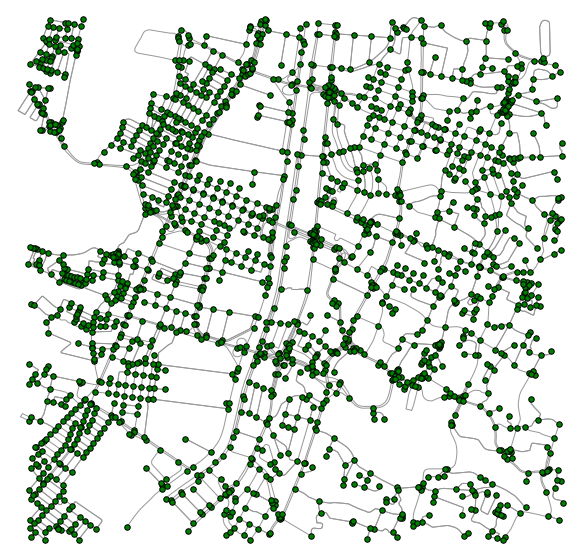

In [3]:
# get a street network and plot it with all edge intersections
address = 'Universidad EAFIT, Carrera 49, La Aguacatala, Comuna 14 - El Poblado, Zona Urbana Medellín, Medellín, Valle de Aburrá, Antioquia, 0500, Colombia'
#address = "Parque Principal Sabaneta, Sabaneta, Valle de Aburrá, Antioquia, 055450, Colombia"
#address = "Parque Lleras, El Poblado, Comuna 14 - El Poblado, Zona Urbana Medellín, Medellín, Valle de Aburrá, Antioquia, 0500, Colombia"
G = ox.graph_from_address(address, network_type='drive', dist=2000)
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(G_proj, fig_height=10, node_color='green', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

In [4]:
G_proj_points, G_proj_ways= ox.graph_to_gdfs(G_proj)

### Clean up the intersections

We'll specify that any nodes with 15 meters of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of cleaned intersections. Then we extract their xy coordinates and plot it to show how the clean intersections below compare to the topological edge intersections above.

In [5]:
# clean up the intersections and extract their xy coords
intersections = ox.consolidate_intersections(G_proj, tolerance=15, dead_ends=True)

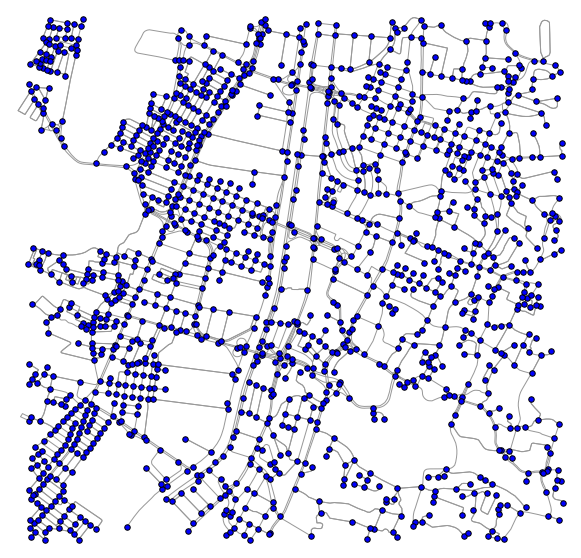

In [6]:
clean_graph = ox.project_graph(intersections)
fig, ax = ox.plot_graph(clean_graph, fig_height=10, node_color='blue', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

## Extract values form the graph

We used the graph G

In [7]:
points, ways = ox.graph_to_gdfs(clean_graph)
mins = points[['lon','lat']].min()
maxs = points[['lon','lat']].max()

In [8]:
area_map_coords = str((mins['lat'],mins['lon'],maxs['lat'],maxs['lon']))
area_map_coords

'(6.182126, -75.5965481, 6.2182703, -75.56041)'

In [9]:
len(points)

1440

## Get places in the map area

In [10]:
from pandas import json_normalize
import requests

url = 'http://overpass-api.de/api/interpreter'  # Overpass API URL
query = f"""
[out:json];
(node
  {area_map_coords}
  ["amenity"="clinic"];
 node
 {area_map_coords}
  ["amenity"="hospital"];
 node
 {area_map_coords}
  ["shop"="chemist"];
 node
 {area_map_coords}
  ["shop"="supermarket"];
 node
 {area_map_coords}
  ["amenity"="bank"];
 node
 {area_map_coords}
  ["highway"="bus_stop"];
);
out;
"""
r = requests.get(url, params={'data': query})
data = r.json()['elements']
places = json_normalize(data) 

In [11]:
len(places)

91

In [12]:
"""
Definition of distance
Args:
  a: tuple of floats (lat, lon)
  b: tuple of floats (lat, lon)
Returns:
  float: distance
"""
def distance(a,b):
  assert type(a) is tuple , "A is not a tuple"
  assert type(b) is tuple , "B is not a tuple"
  assert type(a[0]) is float and type(a[1]) is float, "Values in A are not float"
  assert type(b[0]) is float and type(b[1]) is float, "Values in B are not float"
  # Euclidean distance
  return np.sqrt((a[0]-b[0])**2 + (a[1]- b[1])**2)

In [13]:
from ast import literal_eval
"""
Gets the minium distance between a point and the points that compose a cluster. 
Use the points in G_proj_points of the original graph
Args:
  coor_pl: tuple (lat,lon) of place point
  cluster_point: df 'row' of the cluster point
Returns:
   float min distance in the points of the cluster
"""
def min_distance_cluster_place(coor_pl, cluster_point):
    list_ids = literal_eval(cluster_point['osmid'])
    min_dist = float('inf')
    for i in list_ids:
        point = G_proj_points[G_proj_points['osmid'] == i][['lat','lon']]
        assert len(point) == 1, "Unexpected error, multiple points matched in the first graph"
        coord_point = (float(point['lat']),float(point['lon']))
        dist = distance(coor_pl, coord_point)
        if(dist < min_dist):
          min_dist = dist
    return min_dist

In [ ]:
## Unit test of min_distance_cluster_place
#min_distance_cluster_place((float(2),float(1)) ,points.iloc[1])

In [14]:
points_of_places = {}
for pl_index, pl in places.iterrows():
    coord_pl = (pl['lon'],pl['lat'])
    min_dist = float('inf')
    for po_index, po in points.iterrows():
        coord_po = (po['lon'],po['lat'])
        dist = min_dist
        ## Check if the points comes from a cluster
        if(coord_po[0] is None):
          dist = min_distance_cluster_place(coor_pl, po)
        else:
          dist = distance(coord_pl, coord_po)
        if(dist < min_dist):
            min_dist = dist
            winner = po_index    
    ## Add winner point index to a dict with the place
    points_of_places[pl_index] = winner#, min_dist]
#points_of_places

Points that you may want to see in a different color

In [15]:
want_to_see = []

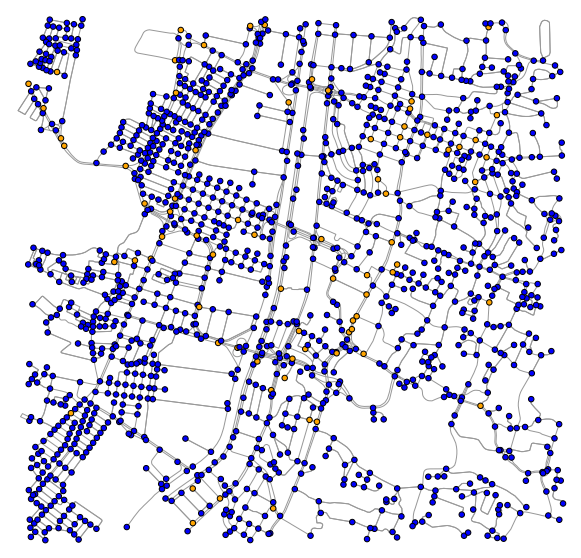

In [16]:
#nc = ['orange' if k in points_of_places.values() else (if k in want_to_see 'purple' else 'blue') for k in list(points.index)]
nc = []
for k in  list(points.index):
    if k in  points_of_places.values():
        if k in want_to_see:
          nc.append('red')
        else:   
          nc.append('orange')
    elif k in want_to_see:
         nc.append('red')
    else:
        nc.append('blue')
fig, ax = ox.plot_graph(clean_graph, fig_height=10, node_color=nc, node_size=30, node_zorder=2, node_edgecolor='k')

## Build output

Build a new index to name our nodes with only ints

In [18]:
nodes_serial_index = {}
for index, old_index in enumerate(list(points.index)):
    nodes_serial_index[old_index] = index
#nodes_serial_index   

Create graph.csv using ways and the new index

In [19]:
out_graph = pd.DataFrame(ways[['u','v','length']])
# Replace u and v with the values in the new index
out_graph['U'] = out_graph['u'].apply(lambda x: nodes_serial_index[x])
out_graph['V'] = out_graph['v'].apply(lambda x: nodes_serial_index[x])
# Drop old colums
out_graph.drop(['u','v'],axis=1, inplace=True)
# Reorder
out_graph = out_graph[['U', 'V', 'length']]
# Save without index
out_graph.to_csv('graph.csv', index=False, header=False)

In [20]:
with open('graph.csv', 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write( str(len(nodes_serial_index)) + '\n' + content)

In [ ]:
out_graph

Create nodes info csv, with the new inde definition

In [21]:
len(points)

1440

In [22]:
out = pd.DataFrame(columns = ['node','isPlace','neightboors'])
for node in list(points.index):
    neightboors = clean_graph.neighbors(node)
    listneightboors = []
    for neightboor in neightboors:
        listneightboors = listneightboors + [nodes_serial_index[neightboor]]
    isPlace = node in points_of_places.values()
    out = out.append({'node': nodes_serial_index[node], 'isPlace': int(isPlace), 'neightboors': listneightboors}, ignore_index=True)
    out = out.drop(columns='neightboors')
out.to_csv(r'nodes_info.csv',index=False, header=False)